In [1]:
import pandas as pd
import numpy as np
import json
import torch

#### Chargement des données

In [2]:
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        test_data = f.readlines()
    return test_data

data_train = load_dataset("./data/train.json")
data_test = load_test_set("./data/test_shuffle.txt")

rows = []
for label, texts in data_train.items():
    for text in texts:
        rows.append({'label': label, 'text': text})

df_train = pd.DataFrame(rows)

labelised = True

if(labelised):
    data_test = load_test_set("./data/labelise.txt")
    rows = []
    for data in data_test:
        label, text = data.split(',',1)
        rows.append({'label': label, 'text': text})
else:
    data_test = load_test_set("./data/test_shuffle.txt")
    rows = []
    for data in data_test:
        rows.append({'text': data})



df_test = pd.DataFrame(rows)
df_test.head()

,label,text
0,Fashion,The impact of fashion on cultural diversity i...
1,Environment,"The benefits of vertical farming are many, in..."
2,Health,The wearable technology tracks sleep patterns...
3,Education,The impact of educational attainment on civic...
4,Entertainment,The rock band announced a reunion tour to cel...


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['label'])
df_test['label'] = le.transform(df_test['label'])

### Data augmentation 

In [7]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas


aug1 = naw.SynonymAug(aug_src='wordnet')
#aug2 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
#aug2 = naw.BackTranslationAug()
#aug = naw.ContextualWordEmbsAug(model_path=, action="substitute")
#aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')



augmented_texts = []
num_augmentations = 1
for text, label in zip(df_train['text'], df_train['label']):
    for _ in range(num_augmentations):
        augmented_text = aug1.augment(text)
        augmented_texts.append({'text': augmented_text, 'label': label})


In [12]:
import nlpaug.augmenter.word as naw

aug1 = naw.SynonymAug(aug_src='wordnet')
#aug2 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
#aug2 = naw.BackTranslationAug()
#aug = naw.ContextualWordEmbsAug(model_path=, action="substitute")
#aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')

augmented_texts = []
num_augmentations = 100
for text, label in zip(df_train['text'], df_train['label']):
    for _ in range(num_augmentations):
        augmented_text = aug1.augment(text)
        augmented_texts.append({'text': augmented_text, 'label': label})
augmented_train_df = pd.DataFrame(augmented_texts)
final_train_df = pd.concat([df_train, augmented_train_df], ignore_index=True)
final_train_df.to_csv('train_augmented_100.csv', index=False)


In [13]:
df_train_aug = pd.read_csv('train_augmented_100.csv')

print(df_train_aug['text'].apply(lambda x: len(x.split())).mean())
print(len(df_train_aug['text']))

11.97084708470847
3636


### Preprocessing

In [10]:
#Let's see use lemmatization and remove stopwords because it is a common practice in text classification tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
"""

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_train_aug['text'] = df_train_aug['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

df_train_aug.head()

,label,text
0,7,mayor announced new initiative improve public ...
1,7,senator facing criticism stance recent bill
2,7,upcoming election ha sparked intense debate am...
3,6,regular exercise balanced diet key maintaining...
4,6,world health organization ha issued new guideline


### Création du modèle

In [14]:
#Before training the model, we will use sentence transformer to encode the text data
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

train_embeddings = model.encode(df_train_aug['text'], show_progress_bar=True)
test_embeddings = model.encode(df_test['text'], show_progress_bar=True)

train_embeddings = torch.tensor(train_embeddings)
test_embeddings = torch.tensor(test_embeddings)

torch.save(train_embeddings, 'train_embeddings_100_entier.pt')
torch.save(test_embeddings, 'test_embeddings_100_entier.pt')

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

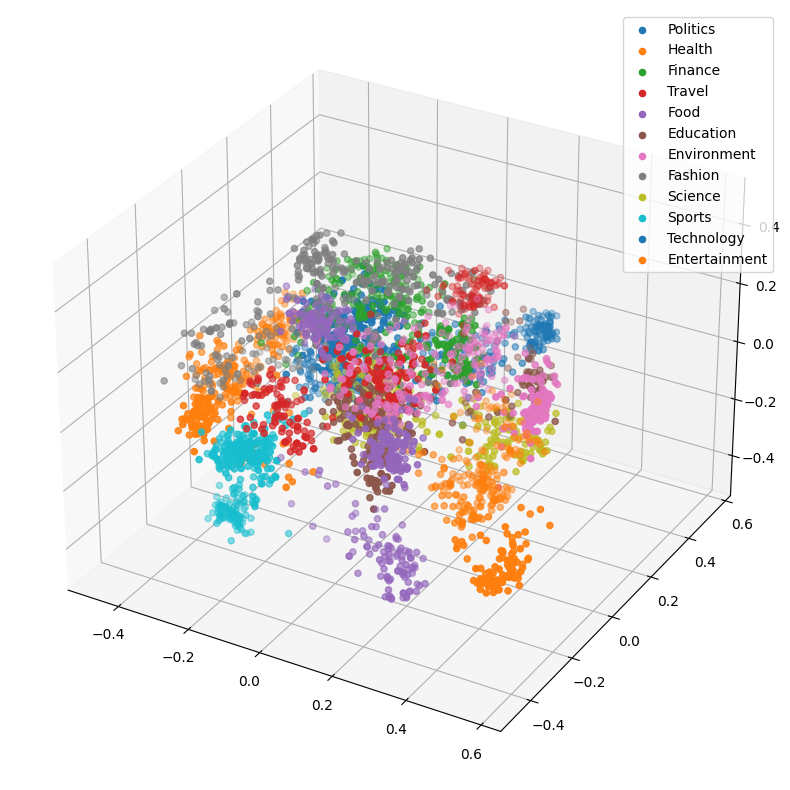

In [23]:
train_embeddings = torch.load('train_embeddings_100_entier.pt')
test_embeddings = torch.load('test_embeddings_100_entier.pt')
#Let's project the embeddings to a 3D space using PCA. We will also show the labels in the legend
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
train_embeddings_pca = pca.fit_transform(train_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for label in df_train_aug['label'].unique():
    indices = df_train_aug['label'] == label
    ax.scatter(train_embeddings_pca[indices, 0], train_embeddings_pca[indices, 1], train_embeddings_pca[indices, 2], label=le.inverse_transform([label])[0])
ax.legend()
plt.show()


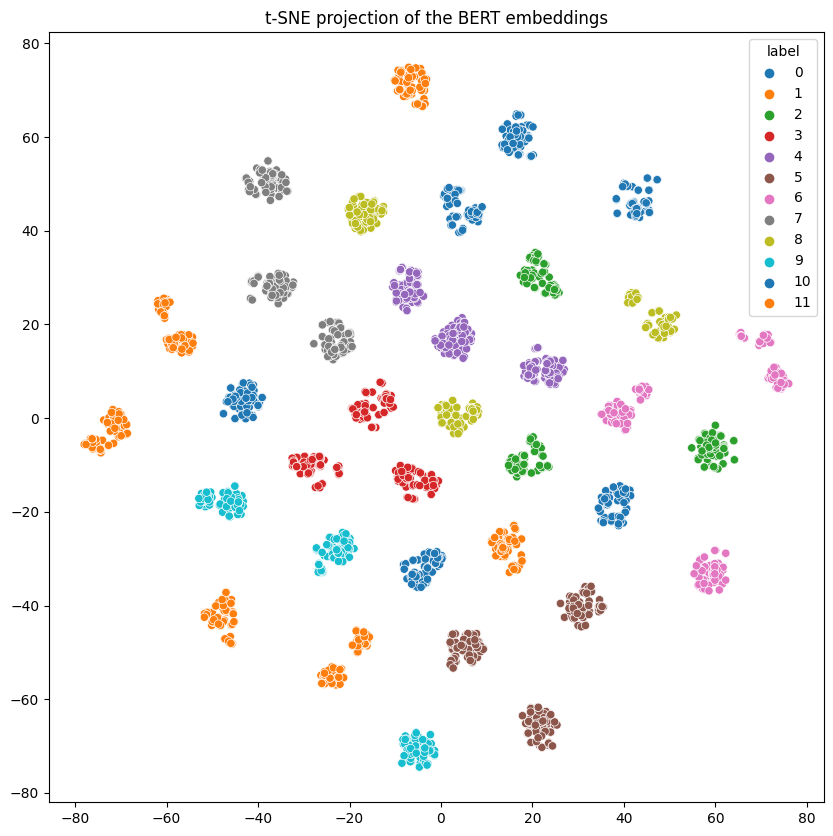

In [18]:
#Let's project the embeddings to 2D space using tsne. We will also show the labels in the legend
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
train_proj = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=train_proj[:, 0], y=train_proj[:, 1], hue=df_train_aug['label'], palette='tab10')
plt.title('t-SNE projection of the BERT embeddings')
plt.show()



SGDClassifier trained
LogisticRegression trained
RandomForestClassifier trained
SVC trained
Ensemble
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        57
           1       0.83      0.84      0.84        58
           2       0.76      0.91      0.83        78
           3       0.84      0.98      0.90        42
           4       0.69      0.78      0.73        37
           5       0.12      0.33      0.18         6
           6       0.99      0.72      0.83       106
           7       0.89      0.85      0.87        60
           8       0.87      0.87      0.87        31
           9       0.85      0.70      0.77        47
          10       0.84      0.81      0.83        32
          11       0.75      0.81      0.78        47

    accuracy                           0.82       601
   macro avg       0.77      0.79      0.77       601
weighted avg       0.84      0.82      0.82       601

Accuracy: 0.8153078202995009


C:\Users\bilel\AppData\Local\Temp\ipykernel_23052\1214277667.py:34: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ensemble_predictions = mode(list_predictions)[0][0]


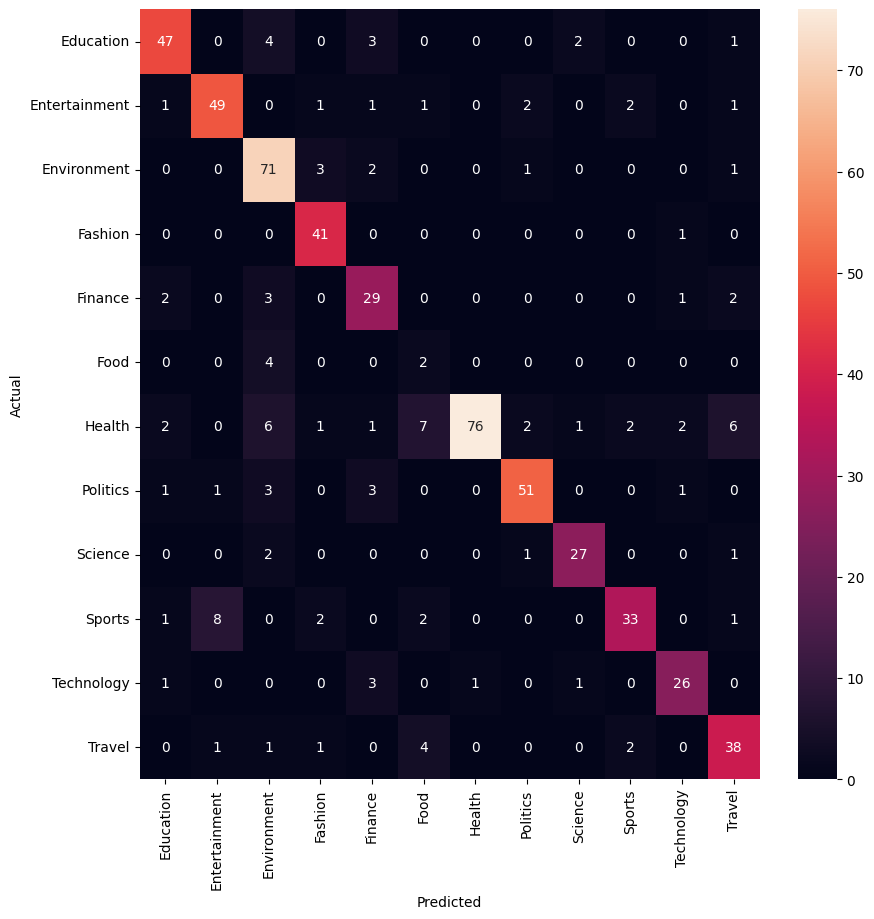

In [11]:
train_embeddings = torch.load('train_embeddings_3_entier.pt')
test_embeddings = torch.load('test_embeddings_3_entier.pt')
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


#Let's give more weights to class 5  and the same to the other 11 classes
weights = {i: 1 for i in range(12)}
weights[5] = 0.6
list_classifiers = [SGDClassifier(loss='hinge', penalty='l2',alpha=0.005, random_state=42,class_weight=weights),
                    LogisticRegression(max_iter=1000, random_state=42,class_weight=weights),
                    RandomForestClassifier(random_state=42, class_weight=weights),
                    SVC(probability=True, random_state=42, class_weight=weights),]



for classifier in list_classifiers:
    classifier.fit(train_embeddings, df_train_aug['label'])
    print(f'{classifier.__class__.__name__} trained')


list_predictions = []
for classifier in list_classifiers:
    predictions = classifier.predict(test_embeddings)
    list_predictions.append(predictions)
#Let's make ensemble predictions
from scipy.stats import mode

ensemble_predictions = mode(list_predictions)[0][0]
print('Ensemble')
print(classification_report(df_test['label'], ensemble_predictions))
print(f"Accuracy: {accuracy_score(df_test['label'], ensemble_predictions)}")



cm = confusion_matrix(df_test['label'], ensemble_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
#Let's save the predictions in a csv submission file in the format ID,label
df_test['label'] = ensemble_predictions
df_test['label'] = le.inverse_transform(df_test['label'])
df_test.head()
df_test.drop('text', axis=1, inplace=True)
df_test['ID'] = df_test.index
df_test = df_test[['ID', 'label']]
df_test.to_csv('submission_ens.csv', index=False)


SGDClassifiertrained
LogisticRegressiontrained
RandomForestClassifiertrained
SVCtrained


C:\Users\bilel\AppData\Local\Temp\ipykernel_20604\1712588599.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ensemble_predictions = mode(list_predictions)[0][0]


Ensemble
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        93
           1       0.75      0.89      0.82       187
           2       0.82      0.90      0.86       154
           3       0.85      0.94      0.89        89
           4       0.81      0.68      0.74        84
           5       0.75      0.89      0.81       208
           7       0.90      0.58      0.71       106
           8       0.77      0.64      0.70        56
          10       0.88      0.51      0.64        75
          11       0.84      0.67      0.75        88

    accuracy                           0.80      1140
   macro avg       0.82      0.76      0.78      1140
weighted avg       0.81      0.80      0.79      1140

Accuracy: 0.7982456140350878


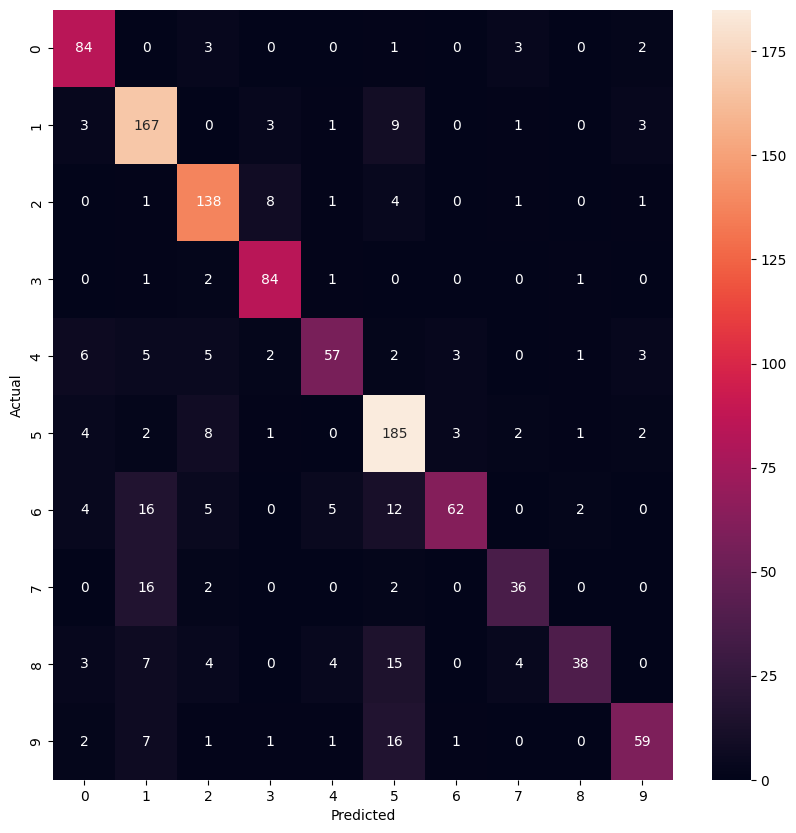

In [93]:
#Let's do another method. Let's put together the class 5 and 6 and put together the class 1 and 9 and rename them to 5 and 1 respectively
df_train_aug['label'] = df_train_aug['label'].replace({6: 5, 9: 1})
df_test['label'] = df_test['label'].replace({6: 5, 9: 1})

weights = {i: 1 for i in range(12)}
weights[5] = 0.5
weights[1] = 1
list_classifiers = [SGDClassifier(loss='hinge', penalty='l2',alpha=0.005, random_state=42,class_weight=weights),
                    LogisticRegression(max_iter=1000, random_state=42,class_weight=weights),
                    RandomForestClassifier(random_state=42, class_weight=weights),
                    SVC(probability=True, random_state=42, class_weight=weights),]

for classifier in list_classifiers:
    classifier.fit(train_embeddings, df_train_aug['label'])
    print(f'{classifier.__class__.__name__}trained')

list_predictions = []
for classifier in list_classifiers:
    predictions = classifier.predict(test_embeddings)
    list_predictions.append(predictions)
    
ensemble_predictions = mode(list_predictions)[0][0]
print('Ensemble')
print(classification_report(df_test['label'], ensemble_predictions))
print(f"Accuracy: {accuracy_score(df_test['label'], ensemble_predictions)}")

cm = confusion_matrix(df_test['label'], ensemble_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [40]:
#Let's create another train et test set containing only the 5 and 6 class. We will train a model on these 2 classes to be able to distinguish them well.
new_df_train_aug = df_train_aug[(df_train_aug['label'] == 5) | (df_train_aug['label'] == 6)]
new_df_test = df_test[(df_test['label'] == 5) | (df_test['label'] == 6)]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
new_train_embeddings = model.encode(new_df_train_aug['text'], show_progress_bar=True)
new_test_embeddings = model.encode(new_df_test['text'], show_progress_bar=True)

new_train_embeddings = torch.tensor(new_train_embeddings)
new_test_embeddings = torch.tensor(new_test_embeddings)

torch.save(new_train_embeddings, 'new_train_embeddings_3_entier.pt')
torch.save(new_test_embeddings, 'new_test_embeddings_3_entier.pt')

new_train_embeddings = torch.load('new_train_embeddings_3_entier.pt')
new_test_embeddings = torch.load('new_test_embeddings_3_entier.pt')

new_list_classifiers = [SGDClassifier(loss='hinge', penalty='l2',alpha=0.005, random_state=42),
                    LogisticRegression(max_iter=1000, random_state=42),
                    RandomForestClassifier(random_state=42),
                    
                    SVC(probability=True, random_state=42)]

new_list_predictions = []
for classifier in new_list_classifiers:
    classifier.fit(new_train_embeddings, new_df_train_aug['label'])
    print(f'{classifier.__class__.__name__} trained')
    predictions = classifier.predict(new_test_embeddings)
    new_list_predictions.append(predictions)
    
new_ensemble_predictions = mode(new_list_predictions)[0][0]
print('Ensemble')
print(classification_report(new_df_test['label'], new_ensemble_predictions))
print(f"Accuracy: {accuracy_score(new_df_test['label'], new_ensemble_predictions)}")


KeyError: 16

In [39]:
new_df_train_aug.head()

,label,text
3,6,Regular exercise and a balanced diet are key t...
4,6,The World Health Organization has issued new g...
5,6,A new study reveals the benefits of meditation...
12,5,The new restaurant in town offers a fusion of ...
13,5,Drinking eight glasses of water a day is essen...


In [12]:
train_embeddings = torch.load('train_embeddings_3.pt')
test_embeddings = torch.load('test_embeddings_3.pt')

#Now we will train a simple feedforward neural network using the embeddings as input
import torch.nn as nn
import torch.optim as optim

class BaseLine(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaseLine, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x_in):
        z1 = self.fc1(x_in)
        a1 = self.relu(z1)
        z2 = self.fc2(a1)
        return z2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = train_embeddings.size(1)
hidden_dim = 128
output_dim = len(le.classes_)
#model = BaseLine(input_dim, hidden_dim, output_dim)
#Let'se use a pre-trained model

from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim):
        super(BertClassifier, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(bert.config.hidden_size, output_dim)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_output = last_hidden_state[:, 0, :]
        output = self.fc(cls_output)
        return output

bert = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)
creterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_embeddings, torch.tensor(df_train_aug['label'].values))
test_dataset = TensorDataset(test_embeddings, torch.tensor(df_test['label'].values))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loss = train(model, train_loader, optimizer, creterion, device)
test_loss = evaluate(model, test_loader, creterion, device)

print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

#Let's see the accuracy
def accuracy(model, iterator, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            output = model(input_ids, attention_mask)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_accuracy = accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

TypeError: list indices must be integers or slices, not str

In [11]:
#Now we will evaluate the model on the test set
test_embeddings = test_embeddings.to(device)
model.eval()
outputs = model(test_embeddings)
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_test['label'], predicted)
print(f'Accuracy: {accuracy}')

from sklearn.metrics import classification_report
print(classification_report(df_test['label'], predicted, target_names=le.classes_))

Accuracy: 0.5333333333333333
               precision    recall  f1-score   support

    Education       0.14      0.09      0.11        93
Entertainment       0.93      0.55      0.69        98
  Environment       0.67      0.65      0.66       154
      Fashion       0.52      0.49      0.51        89
      Finance       0.68      0.69      0.69        84
         Food       0.09      0.11      0.10        27
       Health       0.68      0.61      0.65       181
     Politics       0.67      0.68      0.68       106
      Science       0.47      0.64      0.54        56
       Sports       0.88      0.56      0.68        89
   Technology       0.18      0.48      0.27        75
       Travel       0.51      0.41      0.45        88

     accuracy                           0.53      1140
    macro avg       0.53      0.50      0.50      1140
 weighted avg       0.59      0.53      0.55      1140



In [8]:
#let's print the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 99,980 trainable parameters


In [18]:
#Let's save the model
torch.save(model.state_dict(), 'model_from_scratch.pth')

In [4]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from preprocessing import clean_text

#Now we will train a BERT model on the augmented data using the sentence transformer embeddings

df_train_aug = pd.read_csv('train_augmented_3.csv')
df_train_aug['text'] = df_train_aug['text'].apply(clean_text)

#df_train, df_val = train_test_split(df_train_aug, test_size=0.1, random_state=42)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 15
BATCH_SIZE = 8
EPOCHS = 15

train_dataset = CustomDataset(df_train_aug, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=12)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\bilel\anaconda3\envs\DeepL\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training

In [5]:
losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        labels = batch['label'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Training loss: {avg_train_loss:.4f}')

Epoch 1/15
Training loss: 2.5481
Epoch 2/15
Training loss: 2.3325
Epoch 3/15
Training loss: 1.9874
Epoch 4/15
Training loss: 1.6852
Epoch 5/15
Training loss: 1.3521
Epoch 6/15
Training loss: 1.0655
Epoch 7/15
Training loss: 0.8087
Epoch 8/15
Training loss: 0.6394
Epoch 9/15
Training loss: 0.4891
Epoch 10/15
Training loss: 0.3732
Epoch 11/15
Training loss: 0.2889
Epoch 12/15
Training loss: 0.2344
Epoch 13/15
Training loss: 0.1877
Epoch 14/15
Training loss: 0.1602
Epoch 15/15
Training loss: 0.1326


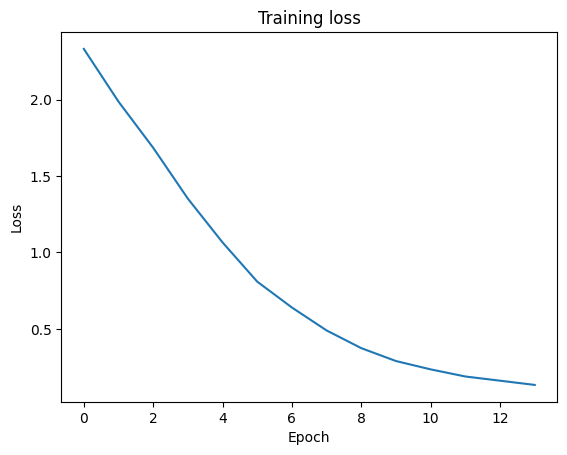

In [6]:
import matplotlib.pyplot as plt

plt.plot(losses[1::])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

### Evaluation du modèle

In [8]:
df_test['text'] = df_test['text'].apply(clean_text)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    attention_mask = batch['attention_mask'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    labels = batch['label']
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6711


In [ ]:
#

### Création du fichier à soumettre

In [9]:
df_test['label'] = predictions
df_test['label'] = le.inverse_transform(df_test['label'])
df_test.head()
df_test.drop('text', axis=1, inplace=True)
df_test['ID'] = df_test.index
df_test = df_test[['ID', 'label']]
df_test.to_csv('submission_test.csv', index=False)